**Зимняя школа “Эконометрика и анализ данных: программирование в R и Python” 11 ноября - 24 ноября 2023, онлайн**

**Тема:** Б.Б. Демешев "Как проверять гипотезы и выглядеть крутым чуваком, если полностью забыл матстат?

**Задание:** "Как я использовал бутстрэп?" с описанием источника данных, оцениваемых параметров, и выводов.

**Задание выполнила** Мельникова Маргарита

# Импорт необходимых библиотек

In [1]:
from arch.bootstrap import IIDBootstrap, IndependentSamplesBootstrap
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import seaborn as sns

# Источник данных
**Источник данных:** датасет из "How to Analyze Your Gender Pay Gap: An Employer’s Guide" (https://www.glassdoor.com/research/how-to-analyze-gender-pay-gap-employers-guide).

Оригинальный источник и методика сбора данных не известна. Возможно, данные взяты из исследования “2019 Glassdoor Data on the Gender Pay Gap and Salary Transparency” (March 2019), Glassdoor survey conducted by The Harris Poll. Available at https://about-content.glassdoor.com//app/uploads/sites/2/2019/03/Gender-Pay-Gap-Fact-Sheet-2019.pdf, которое на 2023.11.11 не было доступно.

Датасет содержит аномизированные данные о сотрудниках неких компаний:

In [2]:
table_descr = pd.DataFrame([['jobTitle', 'название позиции', 'категориальная']
                , ['gender', 'пол', 'категориальная']
                , ['age', 'возраст', 'количественная']
                , ['perfEval', 'видимо, оценка перформанса сотрудника', 'ранговая']
                , ['edu', 'уровень образования', 'категориальная']
                , ['dept', 'департамент', 'категориальная']
                , ['seniority', 'видимо, грейд/разряд сотрудника', 'ранговая']
                , ['basePay', 'базовый оклад, USD', 'количественная']
                , ['bonus', 'базовый оклад, USD', 'количественная']              
               ], columns=['название поля', 'описание поля', 'тип переменной'])

table_descr.style\
            .hide(axis='index')\
            .set_properties(**{'background-color': 'white'})

название поля,описание поля,тип переменной
jobTitle,название позиции,категориальная
gender,пол,категориальная
age,возраст,количественная
perfEval,"видимо, оценка перформанса сотрудника",ранговая
edu,уровень образования,категориальная
dept,департамент,категориальная
seniority,"видимо, грейд/разряд сотрудника",ранговая
basePay,"базовый оклад, USD",количественная
bonus,"базовый оклад, USD",количественная


Посмотрим на данные поближе:

In [3]:
data = pd.read_csv('./data/data.csv')
data.head(1)

,jobTitle,gender,age,perfEval,edu,dept,seniority,basePay,bonus
0,Graphic Designer,Female,18,5,College,Operations,2,42363,9938


In [4]:
print('Пропуски отсутсвуют') if data.isna().sum().sum() == 0 else print('Есть пропуски')

Пропуски отсутсвуют


Рассчитаем совокупный доход:

In [5]:
data['ttlPay'] = data['basePay'] + data['bonus'] 

In [6]:
data['jobTitle'].value_counts()

jobTitle
Marketing Associate    118
Software Engineer      109
Financial Analyst      107
Data Scientist         107
Graphic Designer        98
IT                      96
Sales Associate         94
Driver                  91
Warehouse Associate     90
Manager                 90
Name: count, dtype: int64

In [7]:
data['gender'].value_counts()

gender
Male      532
Female    468
Name: count, dtype: int64

In [8]:
data['edu'].value_counts()

edu
High School    265
Masters        256
College        241
PhD            238
Name: count, dtype: int64

In [9]:
report = data.pivot_table(values='age'
                       , index=['jobTitle']
                       , columns = ['gender']
                       , aggfunc='count'
                       , dropna=True
                       , fill_value=0
                       , margins=True)
report['female_share'] = report['Female'].div(report['All']) * 100
report.reset_index().style.format({ 'Female': '{:,.0f}'
                , 'Male': '{:,.0f}'
                , 'All': '{:,.0f}'
                , 'female_share': '{:,.2f}'
                })\
            .hide(axis='index')\
            .set_properties(**{'background-color': 'white'})

jobTitle,Female,Male,All,female_share
Data Scientist,53,54,107,49.53
Driver,46,45,91,50.55
Financial Analyst,49,58,107,45.79
Graphic Designer,48,50,98,48.98
IT,50,46,96,52.08
Manager,18,72,90,20.00
Marketing Associate,107,11,118,90.68
Sales Associate,43,51,94,45.74
Software Engineer,8,101,109,7.34
Warehouse Associate,46,44,90,51.11


# Гипотеза 1: 
- H0: В ИТ отсутсвует gender gap, то есть доход женщин и мужчин сопоставим  
- HA: В ИТ присутсвует gender gap, то есть доход женщин и мужчин не сопоставим

К IT профессия отнесем следующие роли:
- Software Engineer
- IT
- Data Scientist

То есть будем оценивать разницу средних доходов мужчин и женщин.

Сравним точечные оценки.

In [10]:
it_roles = ['Software Engineer', 'IT', 'Data Scientist']
data_it = data[data['jobTitle'].isin(it_roles)].copy()

print('\nОписательные статистики:')
report = data_it.groupby(['gender'])['ttlPay'].describe().T.reset_index()
report['diff_%'] = (report['Female'].div(report['Male']) - 1) * 100
report.style.format({ 'Female': '{:,.0f}'
                , 'Male': '{:,.0f}'
                , 'diff_%': '{:,.2f}'
                })\
            .hide(axis='index')\
            .set_properties(**{'background-color': 'white'})


Описательные статистики:


index,Female,Male,diff_%
count,111,201,-44.78
mean,"99,829","104,695",-4.65
std,"23,597","24,877",-5.15
min,"45,447","53,598",-15.21
25%,"82,534","88,009",-6.22
50%,"101,905","102,932",-1.00
75%,"116,802","121,525",-3.89
max,"144,389","171,735",-15.92


Построим распределение совокупного дохода в разрезе пола

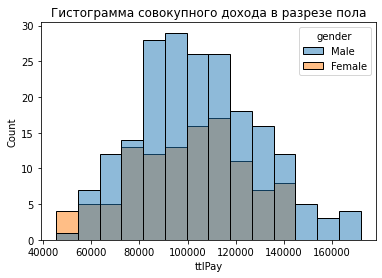

In [11]:
sns.histplot(data=data_it, x='ttlPay', hue='gender')
plt.title('Гистограмма совокупного дохода в разрезе пола')
plt.show()

Оценим доверительный интервал разницы между средними двух выборок при помощи простого (или наивного) бутстрэпа:
- количество симуляций: 10_000
- зафиксируем RNDM_SEED для воспроизводимости симуляций: 42

И напишем для удобства функцию для расчета доверительного интервала, используя готовую реализацию из пакета arch.

In [12]:
RNDM_SEED = 42
TRIALS = 10_000

def mean_diff(x, y):
    '''
    Function to calculate difference of means
    '''
    return np.mean(y) - np.mean(x)

def get_bootstrap_ci(x, y, seed, trials):
    '''
    Function to get CI of difference of means of x and y
    '''
    boot_samples = IndependentSamplesBootstrap(x, y, seed=seed)
    CI_low, CI_high = boot_samples.conf_int(mean_diff, reps=trials, size=0.95, method='basic')
    return CI_low[0], CI_high[0]

Построим 95% доверительный интервал разницы между средними доходами женщин и мужчин в ИТ:

In [13]:
female_data = data_it[data_it['gender']=='Female']['ttlPay'].values
male_data = data_it[data_it['gender']=='Male']['ttlPay'].values
zero_data = male_data * 0

CI_low, CI_high = get_bootstrap_ci(x=female_data
                               , y=male_data
                               , seed=RNDM_SEED
                               , trials=TRIALS)
CI_low, CI_high

(-735.6309701492573, 10454.030519698808)

0 включен в построенный 95% доверительный интервал, следовательно, нет основания отвергать нулевую гипотезу.

Из любопытства построю доверительный интервал доходов женщин и мужчин. Воспользуюсь ранее написанной функцией, подставив в нее нулевой вектор в вычетаемое. 

In [14]:
CI_low, CI_high = get_bootstrap_ci(x=male_data*0
                               , y=male_data
                               , seed=RNDM_SEED
                               , trials=TRIALS)
CI_low, CI_high

(101222.28208955223, 108018.37773631839)

In [15]:
CI_low, CI_high = get_bootstrap_ci(x=female_data*0
                               , y=female_data
                               , seed=RNDM_SEED
                               , trials=TRIALS)
CI_low, CI_high

(95553.09324324325, 104117.88018018017)

## Вывод
0 включен в построенный 95% доверительный интервал, следовательно, нет основания отвергать нулевую гипотезу. Можем сделать вывод, что в наблюдаемых данных отсутсвует gender gap при оплате труда в ИТ.

# Гипотеза 2:
- H0: Доход Financial Analyst сопоставим с Data Scientist
- HA: Доход Financial Analyst отличается от дохода Data Scientist

In [16]:
roles = ['Data Scientist', 'Financial Analyst']
data_comp = data[data['jobTitle'].isin(roles)].copy()

print('\nОписательные статистики:')
report = data_comp.groupby(['jobTitle'])['ttlPay'].describe().T.reset_index()
report['diff_%'] = (report['Financial Analyst'].div(report['Data Scientist']) - 1) * 100
report.style.format({'Data Scientist': '{:,.0f}'
                , 'Financial Analyst': '{:,.0f}'
                , 'diff_%': '{:,.2f}'
                })\
            .hide(axis='index')\
            .set_properties(**{'background-color': 'white'})


Описательные статистики:


index,Data Scientist,Financial Analyst,diff_%
count,107,107,0.00
mean,"98,918","101,404",2.51
std,"21,994","21,197",-3.63
min,"47,688","47,661",-0.06
25%,"82,360","87,219",5.90
50%,"100,322","99,917",-0.40
75%,"112,774","119,458",5.93
max,"144,389","155,151",7.45


Построим распределение совокупного дохода в разрезе выбранных для исследования ролей:

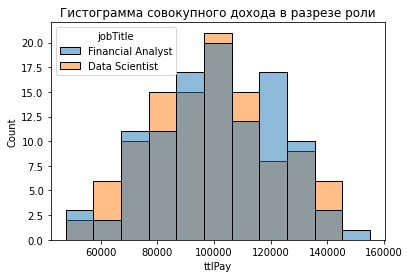

In [17]:
sns.histplot(data=data_comp, x='ttlPay', hue='jobTitle')
plt.title('Гистограмма совокупного дохода в разрезе роли')
plt.show()

Построим 95% доверительный интервал разницы между средними доходами Data Scientist и Financial Analyst:

In [18]:
income_ds = data_comp[data_comp['jobTitle']=='Data Scientist']['ttlPay'].values
income_fa = data_comp[data_comp['jobTitle']=='Financial Analyst']['ttlPay'].values

CI_low, CI_high = get_bootstrap_ci(x=income_ds
                               , y=income_fa
                               , seed=RNDM_SEED
                               , trials=TRIALS)
CI_low, CI_high

(-3349.914719626164, 8174.395093457946)

## Вывод
0 включен в построенный 95% доверительный интервал, следовательно, нет основания отвергать нулевую гипотезу. Можем сделать вывод, что в наблюдаемых данных доход финансовых аналитиков и аналитиков данных сопоставим. Следовательно, "перекатываться" в DS, ориентируясь только на уровень дохода, не стоит.